<a href="https://colab.research.google.com/github/kaiamj/deep-reinforcement-learning-jumanji/blob/main/ProximalPolicyOptimization_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/instadeepai/jumanji.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/instadeepai/jumanji.git to /tmp/pip-req-build-t56ye7j0
  Running command git clone --filter=blob:none --quiet https://github.com/instadeepai/jumanji.git /tmp/pip-req-build-t56ye7j0
  Resolved https://github.com/instadeepai/jumanji.git to commit 10958866909d434ba50edc1915247e4cebc3cb3e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.3/471.3 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/14

In [1]:
import numpy as np
import time
import jax
import jumanji
from jumanji.wrappers import AutoResetWrapper


In [2]:
### use to flatten to observation 
def flatten(obs):
    return np.concatenate([obs.ems.x1,obs.ems.x2,
                        obs.ems.y1,obs.ems.y2,
                        obs.ems.z1,obs.ems.z2,
                        obs.ems_mask.flatten(),obs.items.x_len,
                        obs.items.y_len,obs.items.z_len,
                        obs.items_mask.flatten(),obs.items_placed.flatten()])


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
class FeedForwardNN(nn.Module):
  # def __init__(self):
  #   super(FeedForwardNN, self).__init__()
  def __init__(self, in_dim, out_dim):
    super(FeedForwardNN, self).__init__()
    self.layer1 = nn.Linear(in_dim, 64)
    self.layer2 = nn.Linear(64, out_dim)
    #self.layer3 = nn.Softmax()
  def forward(self, obs):
  # Convert observation to tensor if it's a numpy array
    if isinstance(obs, np.ndarray):
      obs = torch.tensor(obs, dtype=torch.float)
      #print("inside tensor")
  
    activation1 = F.relu(self.layer1(obs))
    output = F.relu(self.layer2(activation1))
    #output = self.layer3(activation2)
    return output

our initial policy, or actor, parameters and value function, or critic, parameters.

## PPO

In [4]:
from torch.distributions import MultivariateNormal,Categorical
from torch.optim import Adam
import pandas as pd
import time


class PPO:
  def __init__(self,env):
    self._init_hyperparameters()
    self.env = env
    
    #initiate actor and critic
    self.actor = FeedForwardNN(self.obs_dim,self.act_dim)
    self.critic = FeedForwardNN(self.obs_dim,1)
    
    self.actor_optim = Adam(self.actor.parameters(), lr=self.lr)
    self.critic_optim = Adam(self.critic.parameters(), lr=self.lr)
    
    
  def _init_hyperparameters(self):
    # Default values for hyperparameters, will need to change later.
    self.timesteps_per_batch = 2  #4800            # timesteps per batch
    #self.max_timesteps_per_episode = 1600      # timesteps per episode
    self.gamma = 0.95
    self.n_updates_per_iteration = 5
    self.clip = 0.2 # As recommended by the paper
    self.lr = 0.005
    
    self.obs_dim = 380
    self.act_dim = 800

  def compute_rtgs(self, batch_rews): 
    # The rewards-to-go (rtg) per episode per batch to return.
    # The shape will be (num timesteps per episode)
    batch_rtgs = []
    # Iterate through each episode backwards to maintain same order
    # in batch_rtgs
    for ep_rews in reversed(batch_rews):
      discounted_reward = 0 # The discounted reward so far
      for rew in reversed(ep_rews):
        # print("rew ",rew)
        discounted_reward = rew + discounted_reward * self.gamma
        # print("discounted reward ",discounted_reward)
        batch_rtgs.insert(0, discounted_reward)
    # Convert the rewards-to-go into a tensor
    # print("batch rtgs ",batch_rtgs)
    batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)
    return batch_rtgs

  def get_action(self,obs,action_tensor):
     p1 = self.actor(obs)
     indices = torch.nonzero(action_tensor)  #getting valid indicies 
     p2 = p1[indices] # getting proper valid action probablities
     p2= torch.reshape(p2,(-1,))  # reshapping it to make it 1D
     probs = Categorical( logits = p2) #logits un-normalized probablities 
     a=probs.sample() #actions
     action_id = indices[a.item()].item()  # valid action value 
     return action_id, a, probs.log_prob(a) 
  
  def rollout(self):
    # batch observations, batch actions, log probs of each action, batch rewards,batch rewards-to-go,episodic lengths in batch
    batch_obs, batch_acts, batch_log_probs, batch_rews, batch_rtgs, batch_lens,batch_states = [], [], [], [], [], [],[]
    
    step_fn = jax.jit(self.env.step)
    reset_fn = jax.jit(self.env.reset)
    t = 0 
    key = jax.random.PRNGKey(np.random.randint(0, 100))
    while t < self.timesteps_per_batch: # Number of timesteps run so far this batch
      # Rewards this episode
      ep_rews = []
      
      
      state, timestep = reset_fn(key)
      ep_t = 1
      rew = 0.0
      while rew == 0.0:
        t += 1 # Increment timesteps ran this batch so far
        obs = flatten(timestep.observation)  # Collect observation
        batch_obs.append(obs)
        
        num_ems, num_items = self.env.action_spec().num_values
        action_mask = timestep.observation.action_mask.flatten()
        action_jnp = jnp.array(action_mask, dtype=jnp.float32)

        action_tensor = torch.tensor(np.array(action_mask),dtype=torch.float)
        ems_item_id, action_,log_prob  = self.get_action(obs,action_tensor) 
        #%time ems_item_id, action_2,log_prob2  = self.get_action_jax(obs,action_jnp)         
        
        
        ems_id, item_id = jnp.divmod(ems_item_id, num_items)
        action = jnp.array([ems_id, item_id])  # Wrap the action as a jax array of shape (2,)
        batch_states.append(state)
        state,timestep = step_fn(state, action)
        rew = np.array(timestep.reward.flatten())[0]
        # print("rew in  ", rew)
        ep_rews.append(rew)
        batch_acts.append(action_)
        batch_log_probs.append(log_prob)
        
      batch_rews.append(ep_rews) 
    batch_obs = torch.tensor(batch_obs, dtype=torch.float)
    batch_acts = torch.tensor(batch_acts, dtype=torch.float)
    batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float)
    batch_rtgs = self.compute_rtgs(batch_rews)
    return batch_obs, batch_acts,batch_log_probs, batch_rtgs, t ,rew,batch_states

  def learn(self, total_timesteps):
    t_so_far = 0 # Timesteps simulated so far
    episode_reward = []
    while t_so_far < total_timesteps:              # ALG STEP 
      batch_obs, batch_acts,batch_log_probs, batch_rtgs, batch_lens,rew,batch_states = self.rollout()
      episode_reward.append(rew)
      t_so_far += batch_lens # Calculate how many timesteps we collected this batch 
    
      V, _ = self.evaluate(batch_obs, batch_acts)
  
      A_k = batch_rtgs - V.detach()  # ALG STEP 5 Calculate advantage
      A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10) # Normalize advantages
      for i in range(self.n_updates_per_iteration):
        V, curr_log_probs = self.evaluate(batch_obs, batch_acts)
        ratios = torch.exp(curr_log_probs - batch_log_probs)   # Calculate ratios
        surr1 = ratios * A_k  # Calculate surrogate losses
        surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k
        actor_loss = (-torch.min(surr1, surr2)).mean()
        # Calculate gradients and perform backward propagation for actor 
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()
        critic_loss = nn.MSELoss()(V, batch_rtgs)
        # Calculate gradients and perform backward propagation for critic network    
        self.critic_optim.zero_grad()    
        critic_loss.backward()    
        self.critic_optim.step()
    return episode_reward,batch_states
    
  def evaluate(self, batch_obs,batch_acts):
    # Query critic network for a value V for each obs in batch_obs.
    V = self.critic(batch_obs).squeeze()
    mean = self.actor(batch_obs)
    dist = Categorical(mean)
    log_probs = dist.log_prob(batch_acts)
 
    return V, log_probs  # Return predicted values V and log probs log_probs
 
  

In [6]:
key = jax.random.PRNGKey(0)
env = jumanji.make("BinPack-toy-v0")
model = PPO(env)
%time  episode_rewards,batch_states = model.learn(1)


/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/lax_numpy.py:174: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have i

CPU times: user 11.9 s, sys: 139 ms, total: 12 s
Wall time: 12.4 s


<ipython-input-4-461af8fbfc3b>:117: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  batch_obs = torch.tensor(batch_obs, dtype=torch.float)


Text(0, 0.5, 'Reward')

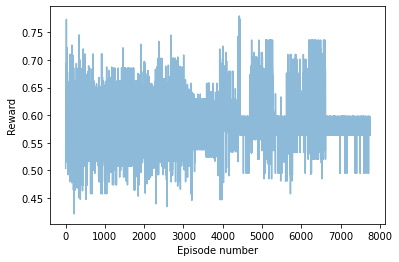

In [ ]:
import matplotlib.pyplot as plt
plt.plot(episode_rewards, alpha=0.5)
plt.xlabel('Episode number')
plt.ylabel('Reward')

In [ ]:
np.mean(episode_rewards)

0.58722776

In [ ]:
yani = env._env_viewer.animation(batch_states)
from IPython.display import HTML
HTML(ani.to_html5_video())

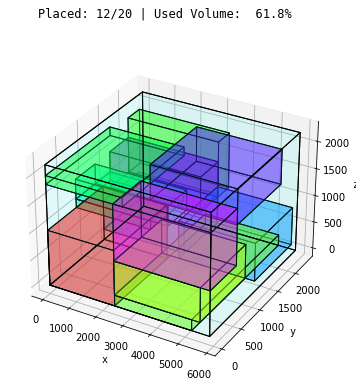

In [ ]:

import time

for i in batch_states:
  
  env.render(i)
  time.sleep(0.2)
#print("Printed after 2.4 seconds.")


In [ ]:
from IPython.display import HTML

In [ ]:
HTML(ani.to_html5_video())